In [2]:
#Score: 0.87937

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [4]:
#数据加载
train_data = pd.read_csv('./fraud-detection-in-insurance-claims/train.csv')
test_data = pd.read_csv('./fraud-detection-in-insurance-claims/test.csv')

In [5]:
datas = pd.concat((train_data, test_data))
datas.reset_index(drop=True, inplace=True)

## 数据探索

In [6]:
cat_columns = datas.select_dtypes(include=['O']).columns
numerical_columns = datas.select_dtypes(exclude=['O']).columns

In [7]:
col_name = []
unique_value = []
for col in cat_columns:
    # print(col, datas[col].nunique())
    col_name.append(col)
    unique_value.append(datas[col].nunique())

df_cat_col_unique = pd.DataFrame()
df_cat_col_unique['col_name'] = col_name
df_cat_col_unique['unique_value'] = unique_value
df_cat_col_unique = df_cat_col_unique.sort_values('unique_value', ascending= False)
# df_cat_col_unique

In [8]:
col_name = []
unique_value = []
for col in numerical_columns:
    # print(col, datas[col].nunique())
    col_name.append(col)
    unique_value.append(datas[col].nunique())

df_numerical_col_unique = pd.DataFrame()
df_numerical_col_unique['col_name'] = col_name
df_numerical_col_unique['unique_value'] = unique_value
df_numerical_col_unique = df_numerical_col_unique.sort_values('unique_value', ascending= False)
# df_numerical_col_unique

In [9]:
df_cat_col_unique
# df_numerical_col_unique

,col_name,unique_value
6,incident_location,1000
16,policy_bind_date,951
5,incident_date,60
2,auto_model,39
11,insured_hobbies,20
12,insured_occupation,14
1,auto_make,14
10,insured_education_level,7
4,incident_city,7
8,incident_state,7


## 特征工程

#### 标签编码 policy_bind_date、incident_date

In [10]:
datas['policy_bind_date'] = pd.to_datetime(datas['policy_bind_date'])
datas['incident_date'] = pd.to_datetime(datas['incident_date'])

In [11]:
datas['policy_bind_date_year'] = datas['policy_bind_date'].dt.year
datas['policy_bind_date_month'] = datas['policy_bind_date'].dt.month
datas['policy_bind_date_day'] = datas['policy_bind_date'].dt.day
datas['policy_bind_date_weekday'] = datas['policy_bind_date'].dt.weekday

datas['incident_date_year'] = datas['incident_date'].dt.year
datas['incident_date_month'] = datas['incident_date'].dt.month
datas['incident_date_day'] = datas['incident_date'].dt.day
datas['incident_date_weekday'] = datas['incident_date'].dt.weekday

In [12]:
# 查看最小、最大日期
# datas.policy_bind_date.min() #1990-01-08
# datas.policy_bind_date.max() #2015-02-22

# datas.incident_date.min() #2015-01-01
# datas.incident_date.max() #2015-03-01

In [13]:
base_date = datas.policy_bind_date.min()
#转换为diff
datas['policy_bind_date_diff'] = (datas['policy_bind_date'] - base_date).dt.days
datas['incident_date_diff'] = (datas['incident_date'] - base_date).dt.days
datas['incident_date&policy_bind_date_diff'] = datas['incident_date_diff'] - datas['policy_bind_date_diff']

In [14]:
datas

,_c39,age,authorities_contacted,auto_make,auto_model,auto_year,bodily_injuries,capital-gains,capital-loss,collision_type,...,policy_bind_date_month,policy_bind_date_day,policy_bind_date_weekday,incident_date_year,incident_date_month,incident_date_day,incident_date_weekday,policy_bind_date_diff,incident_date_diff,incident_date&policy_bind_date_diff
0,NaN,37,Ambulance,Nissan,Maxima,2000,0,60100,0,Side Collision,...,8,8,3,2015,1,16,4,8613,9139,526
1,NaN,44,Other,Honda,Civic,1996,2,33200,0,Side Collision,...,12,25,3,2015,1,27,1,2908,9150,6242
2,NaN,33,Police,Jeep,Wrangler,2002,2,0,-45200,Side Collision,...,1,19,4,2015,1,24,5,2202,9147,6945
3,NaN,42,Fire,Suburu,Legacy,2003,2,0,-49000,Front Collision,...,10,28,1,2015,2,6,4,6868,9160,2292
4,NaN,30,Fire,Ford,F150,2004,2,72400,-77000,Rear Collision,...,12,9,6,2015,2,20,4,4353,9174,4821
5,NaN,48,Police,Saab,93,1996,0,11000,0,Rear Collision,...,8,6,4,2015,1,4,6,3497,9127,5630
6,NaN,48,Fire,Toyota,Highlander,2013,0,54900,-36700,Side Collision,...,6,22,0,2015,1,25,6,7105,9148,2043
7,NaN,29,Ambulance,Suburu,Legacy,2012,2,71400,0,Side Collision,...,12,4,1,2015,2,23,0,6539,9177,2638
8,NaN,41,Ambulance,Dodge,RAM,2004,1,43700,-66300,Rear Collision,...,11,2,1,2015,1,23,4,7603,9146,1543
9,NaN,41,Ambulance,Saab,92x,2007,1,71300,-70300,Front Collision,...,12,7,0,2015,1,4,6,3255,9127,5872


In [15]:
#检查单个特征
# datas.incident_city.nunique()
datas.incident_city.value_counts()

Springfield    157
Arlington      152
Columbus       149
Northbend      145
Hillsdale      141
Riverwood      134
Northbrook     122
Name: incident_city, dtype: int64

In [16]:
datas.drop(['policy_bind_date', 'incident_date', '_c39', 'incident_location', 'policy_number', 'insured_zip'], axis= 1, inplace=True)

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
cat_columns = datas.select_dtypes(include= ['O']).columns

In [19]:
for col in cat_columns:
    le = LabelEncoder()
    datas[col] = le.fit_transform(datas[col])

datas[cat_columns]

,authorities_contacted,auto_make,auto_model,collision_type,incident_city,incident_severity,incident_state,incident_type,insured_education_level,insured_hobbies,insured_occupation,insured_relationship,insured_sex,police_report_available,policy_csl,policy_state,property_damage
0,0,9,26,3,5,2,0,2,5,15,10,1,0,0,2,1,0
1,3,6,10,3,6,1,0,0,3,14,2,2,1,2,1,0,0
2,4,7,36,3,3,2,6,2,2,16,6,5,0,1,2,0,0
3,1,11,21,1,3,0,6,0,3,18,13,3,1,2,2,2,2
4,1,5,14,2,3,2,4,0,4,18,2,3,0,2,0,2,2
5,4,10,2,2,6,0,4,0,3,17,0,4,0,1,0,1,2
6,1,12,18,3,0,2,1,0,6,9,3,2,1,1,1,1,0
7,0,11,21,3,1,1,6,0,6,3,1,1,0,2,2,1,1
8,0,4,30,2,2,2,4,0,4,18,8,0,0,0,0,2,1
9,0,10,1,1,1,0,1,0,2,4,11,2,0,2,1,0,0


In [20]:
# 数据集切分
train = datas[datas['fraud_reported'].notnull()]
test = datas[datas['fraud_reported'].isnull()]

In [21]:
train_X = train.drop(['fraud_reported'], axis=1)
train_y = train['fraud_reported']
test_X = test.drop(['fraud_reported'], axis=1)

## 使用lgbm 训练

In [22]:
import lightgbm as lgb

In [23]:
model_lgb = lgb.LGBMClassifier(
            num_leaves=2**5-1, reg_alpha=0.25, reg_lambda=0.25, objective='binary',
            max_depth=-1, learning_rate=0.005, min_child_samples=3, random_state=2022,
            n_estimators=2000, subsample=1, colsample_bytree=1,
        )

In [24]:
model_lgb.fit(train_X, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
        importance_type='split', learning_rate=0.005, max_depth=-1,
        min_child_samples=3, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=2000, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=2022, reg_alpha=0.25, reg_lambda=0.25, silent=True,
        subsample=1, subsample_for_bin=200000, subsample_freq=0)

In [25]:
y_pred = model_lgb.predict_proba(test_X)[:, 1]

In [26]:
y_pred

array([  1.35247713e-02,   1.60331250e-01,   1.05960096e-02,
         2.41906138e-02,   1.74570020e-03,   4.51793232e-02,
         2.84019624e-03,   3.11774698e-02,   1.49329891e-03,
         5.10800100e-03,   4.19436882e-02,   4.55532178e-03,
         7.17428829e-01,   1.98613207e-03,   4.84653742e-03,
         6.09905385e-01,   1.57479658e-02,   1.28733610e-02,
         6.07172531e-01,   8.97263382e-03,   1.01178616e-02,
         3.16632508e-01,   8.97843512e-01,   1.79593914e-02,
         1.26203408e-02,   9.57932112e-01,   2.58267823e-03,
         9.94068970e-03,   2.57925833e-01,   2.70152874e-02,
         9.16212789e-01,   5.27231212e-02,   5.05088842e-01,
         4.93674014e-03,   3.42050968e-02,   9.32558508e-03,
         6.56120178e-01,   2.59597041e-03,   1.04017854e-03,
         1.02261042e-01,   7.18829155e-01,   5.80361966e-03,
         5.30764282e-03,   8.63291346e-03,   1.13248988e-02,
         5.63133448e-03,   5.69755354e-03,   1.39067237e-02,
         4.66212837e-01,

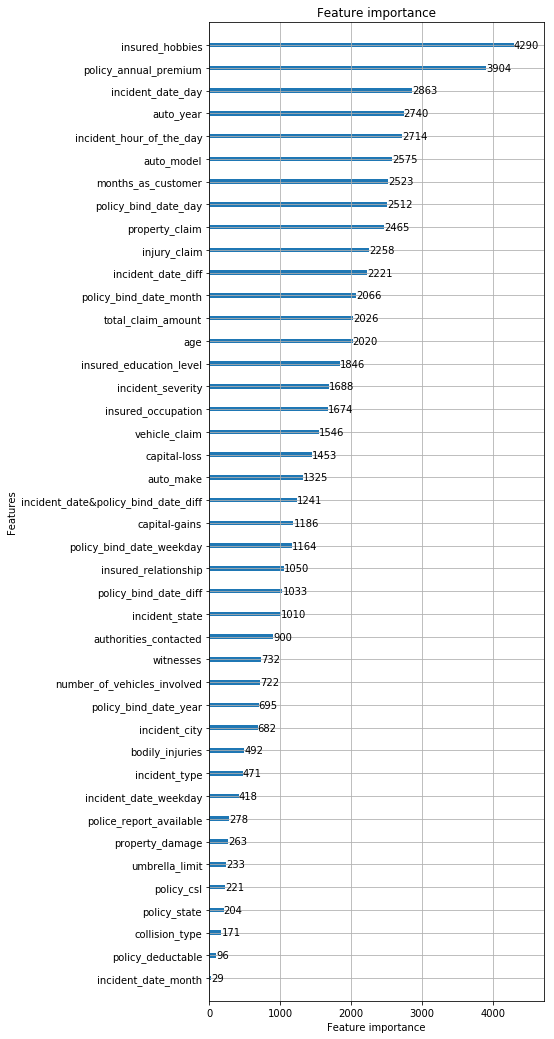

In [28]:
fig, ax = plt.subplots(figsize=(6,18))
lgb.plot_importance(model_lgb, max_num_features=50, ax = ax)

In [51]:
submission = pd.read_csv('./fraud-detection-in-insurance-claims/sampleSubmission.csv')
submission['fraud_reported'] = y_pred
submission.to_csv('./submission/submission.csv', index=None)